In [ ]:
pip install category_encoders

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import mord

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import make_scorer, confusion_matrix, classification_report, r2_score, roc_curve, mean_squared_error, auc, mean_absolute_error



from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, KFold


# 1. Data cleaning

Extract the detailed description of each question/column, which is the first row of the dataframe, save it into "questions". And remove this row from original dataframe.

In [2]:
df_origin = pd.read_csv("clean_kaggle_data_2020.csv")
df = df_origin.copy()
questions = df.iloc[0,:]
df = df.iloc[1:,:]

/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,206) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Check proportion of two different types of questions:
- single choice questions
- select all that apply 

In [3]:
# check single choice questions
columns_single = df.filter(regex="^(?!.*Part)(?!.*OTHER)").columns
df[columns_single].describe()
print(f"Number of single choice questions: {columns_single.shape[0]-2}") 


# check multiple choice questions
columns_multiple = df.filter(regex="^(?=.*Part)|(?=.*OTHER)").columns
#df[columns_multiple].describe()
print(f"\nNumber of multiple choice questions: {columns_multiple.shape[0]}")

print("\nSingle choice questions:", columns_single)

Number of single choice questions: 19

Number of multiple choice questions: 336

Single choice questions: Index(['Time from Start to Finish (seconds)', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5',
       'Q6', 'Q8', 'Q11', 'Q13', 'Q15', 'Q20', 'Q21', 'Q22', 'Q24', 'Q25',
       'Q30', 'Q32', 'Q38', 'Q24_Encoded', 'Q24_buckets'],
      dtype='object')


First, we have all of the single choice questions.    

Check the percentage of nan values within each single choice question.

We set the threshold of percentage = 0.5. If percentage of missing values >= 0.5, we choose to drop the corresponding columns.    

Here we drop "Q30" and "Q32".    


In [4]:
single = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q8', 'Q11', 'Q13', 'Q15', 'Q20', 'Q21', 'Q22', 'Q25',
       'Q30', 'Q32', 'Q38']
single_nan=[]

for i in single:
    percent = df[i].isna().sum()/len(df[i])

    single_nan.append(percent)

print("Percentage of missing values in single choice questions:\n", single_nan)

for i in range(len(single_nan)):
    if single_nan[i]>=0.5:
        df = df.drop([single[i]],axis=1)

Percentage of missing values in single choice questions:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052288190884518596, 0.052288190884518596, 0.052288190884518596, 0.052288190884518596, 0.0, 0.0, 0.0, 0.014819647683847517, 0.6725696709851804, 0.8603784136452605, 0.11678628017522602]


Now, we will deal with the single choice questions having ordinal implications together using ordinal encoder.   

Notice that, we count such answers "other", "i don't know" as seldom, never or none.

Q1, Q6, Q4, Q13, Q15, Q20, Q21, Q22, Q25

In [5]:
#Q1 age 18-21:0, 22-24:1, 25-29:2, ....., 70:10
order = OrdinalEncoder()
df['Q1'] = order.fit_transform(df['Q1'].values.reshape(-1,1))

In [6]:
#Q6
df.loc[df['Q6']=='I have never written code','Q6']=0
df.loc[df['Q6']=='< 1 years','Q6']=1
df.loc[df['Q6']=='1-2 years','Q6']=2
df.loc[df['Q6']=='3-5 years','Q6']=3
df.loc[df['Q6']=='5-10 years','Q6']=4
df.loc[df['Q6']=='10-20 years','Q6']=5
df.loc[df['Q6']=='20+ years','Q6']=6

df['Q6'] = order.fit_transform(df['Q6'].values.reshape(-1,1))

#Q4
df.loc[df['Q4']=='No formal education past high school','Q4']=0
df.loc[df['Q4']=='I prefer not to answer','Q4']=0
df.loc[df['Q4']=='Some college/university study without earning a bachelor’s degree','Q4']=1
df.loc[df['Q4']=='Bachelor’s degree','Q4']=2
df.loc[df['Q4']=='Master’s degree','Q4']=3
df.loc[df['Q4']=='Doctoral degree','Q4']=4
df.loc[df['Q4']=='Professional degree','Q4']=5

df['Q4'] = order.fit_transform(df['Q4'].values.reshape(-1,1))

#Q13 encoder encounter NaN, fill NaN with mode
df['Q13'].fillna(df['Q13'].mode()[0],inplace=True)
df.loc[df['Q13']=='Never','Q13']=0
df.loc[df['Q13']=='Once','Q13']=1
df.loc[df['Q13']=='2-5 times','Q13']=2
df.loc[df['Q13']=='6-25 times','Q13']=3
df.loc[df['Q13']=='More than 25 times','Q13']=4

df['Q13'] = order.fit_transform(df['Q13'].values.reshape(-1,1))

#Q15
df['Q15'].fillna(df['Q15'].mode()[0],inplace=True)
df.loc[df['Q15']=='I do not use machine learning methods','Q15']=0
df.loc[df['Q15']=='Under 1 year','Q15']=1
df.loc[df['Q15']=='1-2 years','Q15']=2
df.loc[df['Q15']=='2-3 years','Q15']=3
df.loc[df['Q15']=='3-4 years','Q15']=4
df.loc[df['Q15']=='4-5 years','Q15']=5
df.loc[df['Q15']=='5-10 years','Q15']=6
df.loc[df['Q15']=='10-20 years','Q15']=7
df.loc[df['Q15']=='20 or more years','Q15']=8

df['Q15'] = order.fit_transform(df['Q15'].values.reshape(-1,1))

#Q20 size of company
df['Q20'].fillna(df['Q20'].mode()[0],inplace=True)
df.loc[df['Q20']=='0-49 employees','Q20']=0
df.loc[df['Q20']=='50-249 employees','Q20']=1
df.loc[df['Q20']=='250-999 employees','Q20']=2
df.loc[df['Q20']=='1000-9,999 employees','Q20']=3
df.loc[df['Q20']=='10,000 or more employees','Q20']=4

df['Q20'] = order.fit_transform(df['Q20'].values.reshape(-1,1))

#Q21 size of company
df['Q21'].fillna(df['Q21'].mode()[0],inplace=True)
df.loc[df['Q21']=='0','Q21']=0
df.loc[df['Q21']=='1-2','Q21']=1
df.loc[df['Q21']=='3-4','Q21']=2
df.loc[df['Q21']=='5-9','Q21']=3
df.loc[df['Q21']=='10-14','Q21']=4
df.loc[df['Q21']=='15-19','Q21']=5
df.loc[df['Q21']=='20+','Q21']=6


df['Q21'] = order.fit_transform(df['Q21'].values.reshape(-1,1))

#Q22 how long incorporate machine learning methods
df['Q22'].fillna(df['Q22'].mode()[0],inplace=True)
df.loc[df['Q22']=='We are exploring ML methods (and may one day put a model into production)','Q22']=1
df.loc[df['Q22']=='We use ML methods for generating insights (but do not put working models into production)','Q22']=2
df.loc[df['Q22']=='We recently started using ML methods (i.e., models in production for less than 2 years)','Q22']=3
df.loc[df['Q22']=='We have well established ML methods (i.e., models in production for more than 2 years)','Q22']=4
df.loc[df['Q22']=='No (we do not use ML methods)','Q22']=0
df.loc[df['Q22']=='I do not know','Q22']=0


df['Q22'] = order.fit_transform(df['Q22'].values.reshape(-1,1))

#Q25
df['Q25'].fillna(df['Q25'].mode()[0],inplace=True)
df.loc[df['Q25']=='$0 ($USD)','Q25']=0
df.loc[df['Q25']=='$1-$99','Q25']=1
df.loc[df['Q25']=='$100-$999','Q25']=2
df.loc[df['Q25']=='$1000-$9,999','Q25']=3
df.loc[df['Q25']=='$10,000-$99,999','Q25']=4
df.loc[df['Q25']=='$100,000 or more ($USD)','Q25']=5

df['Q25'] = order.fit_transform(df['Q25'].values.reshape(-1,1))

Now, we will deal with the single choice questions using target encoder.


In [7]:
#Q2 keep that man=0 and woman=1
df = df[(df['Q2']!='Nonbinary')&(df['Q2']!='Prefer not to say')&(df['Q2']!='Prefer to self-describe')]
label = LabelEncoder()
df['Q2'] = label.fit_transform(df['Q2'])


In [8]:
import category_encoders as ce
x=['Q3','Q5','Q8','Q11','Q38']
for i in x:
    encoder = ce.TargetEncoder()
    df = df[df[i]!='Other']
    df = df[df[i]!='None']
    df[i] = encoder.fit_transform(df[i], df['Q24_Encoded'])

Then, we have all of the multiple choice questions. We drop 'other' and 'none' part of each question.

Notice that, when we combine multiple parts of one certain question, we drop samples have null values..

In [9]:
df = df.drop(df.columns[df.columns.str.contains('OTHER')].tolist(),axis=1)
df = df.drop(df.columns[df.columns.str.contains('None')].tolist(),axis=1)

In [ ]:
#df.drop(df.columns[df.columns.str.contains('A')].tolist(),axis=1,inplace=True)
#df.drop(df.columns[df.columns.str.contains('B')].tolist(),axis=1,inplace=True)

In [10]:
multi = ['Q7','Q9','Q10','Q12','Q14','Q16','Q17','Q18','Q19','Q23','Q26','Q27','Q28','Q29','Q31',
        'Q33','Q34','Q35','Q36','Q37','Q39']

check_percent=[]
for q in multi:
    x = np.zeros(df.shape[0])
    for i in df.columns[df.columns.str.contains(q)]:
        label = LabelEncoder()
        df[i] = label.fit_transform(df[i])
        x=x+df[i]
    check_percent.append(x.isin([np.float64(1)]).sum()/df.shape[0])

check_percent

[0.0,
 0.0006439979392065945,
 0.0005151983513652757,
 0.055770221535291084,
 0.0006439979392065945,
 0.0003863987635239567,
 0.006826378155589902,
 0.025373518804739825,
 0.026403915507470375,
 0.046239052035033486,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0005151983513652757,
 0.0016743946419371459,
 0.005023183925811438]

In [11]:
df = df.drop(['Time from Start to Finish (seconds)'], axis=1)

In [12]:
df.shape

(7764, 325)

# 2. Exploratory data analysis and feature selection

**Exploratory data analysis: (on whole dataset)**

1. Check on target variable.
2. check number of years in writing code v.s salary.
3. Check on the correltion of different features with the target variable. Order their importance in descending order.
4. Show pair-wise correlations of different features in both pairplot and heatmap.

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


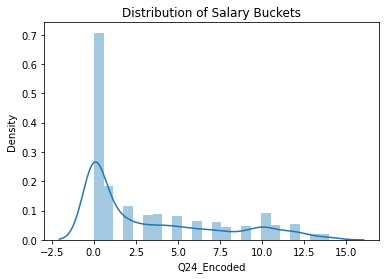

In [13]:
#1. show distribution of target variable
sns.distplot(df['Q24_Encoded'])
plt.title('Distribution of Salary Buckets')
plt.show()

Text(0.5, 1.0, 'Number of years writing code (label) v.s Salary level (x-axis)')

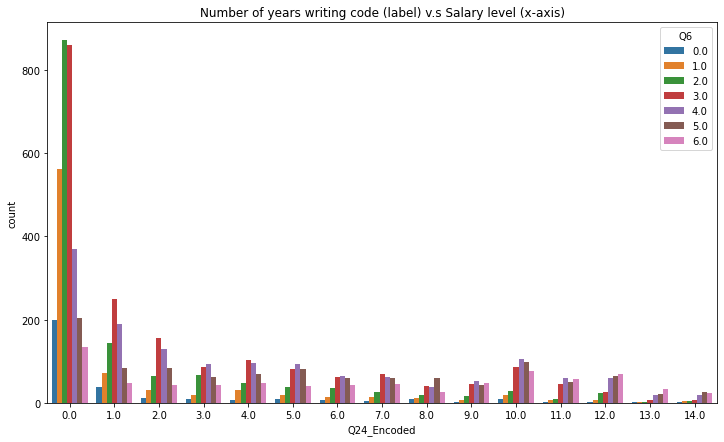

In [14]:
# 2. check number of years. writing code v.s salary
plt.figure(figsize=(12,7))
sns.countplot(x='Q24_Encoded',hue='Q6', data=df)
plt.title("Number of years writing code (label) v.s Salary level (x-axis)")

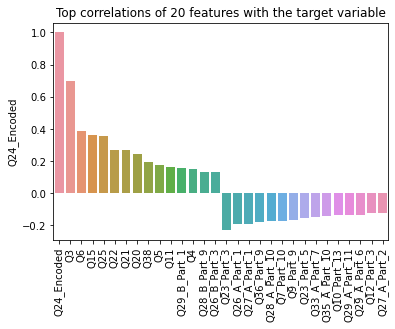

In [15]:
#3. correltion (absolute value) with the target variable
relation_pos = pd.DataFrame(df[df.columns[1:]].corr()['Q24_Encoded'][:].sort_values(ascending=False)[:15])
relation_neg = pd.DataFrame(df[df.columns[1:]].corr()['Q24_Encoded'][:].sort_values(ascending=True)[:15])
relation = pd.concat([relation_pos,relation_neg], axis=0)

ax = sns.barplot(x=relation.index, y='Q24_Encoded', data=relation)
ax.set_xticklabels(labels=relation.index, rotation=90)

plt.title('Top correlations of 20 features with the target variable')
plt.show()

<Figure size 360x360 with 0 Axes>

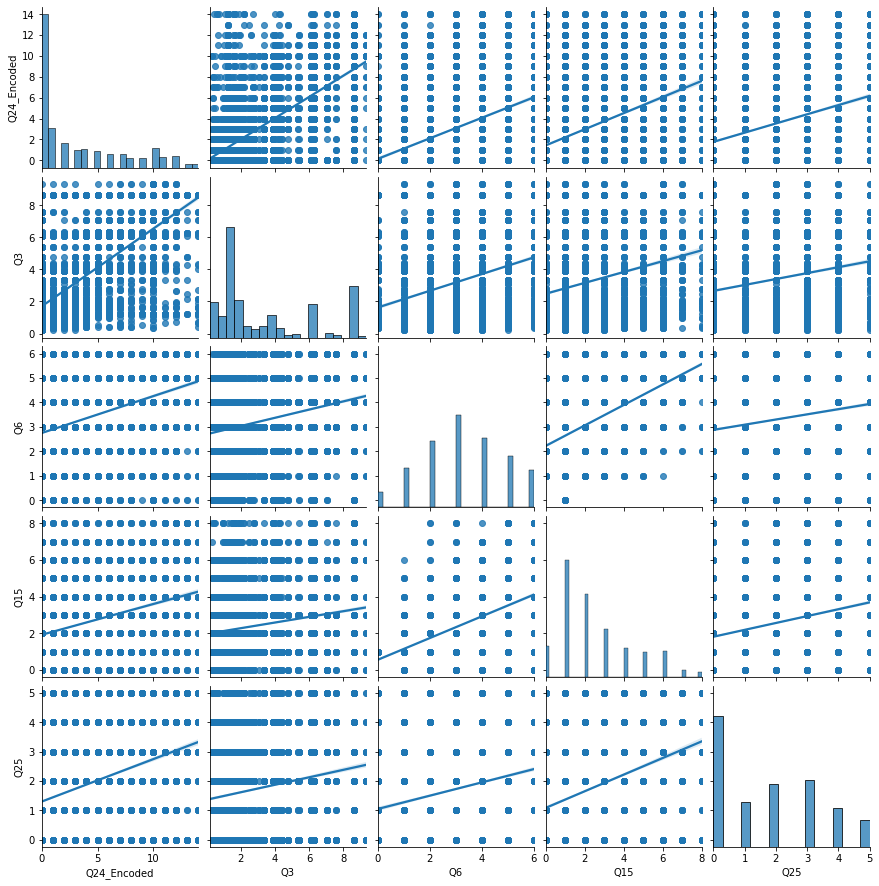

In [17]:
#4. pair-wise positive correlation between top 5 features
plt.figure(figsize=(5,5))
features_pos = df.loc[:,(relation_pos.index[:5])]
sns.pairplot(features_pos, kind='reg')
plt.show()

<Figure size 360x360 with 0 Axes>

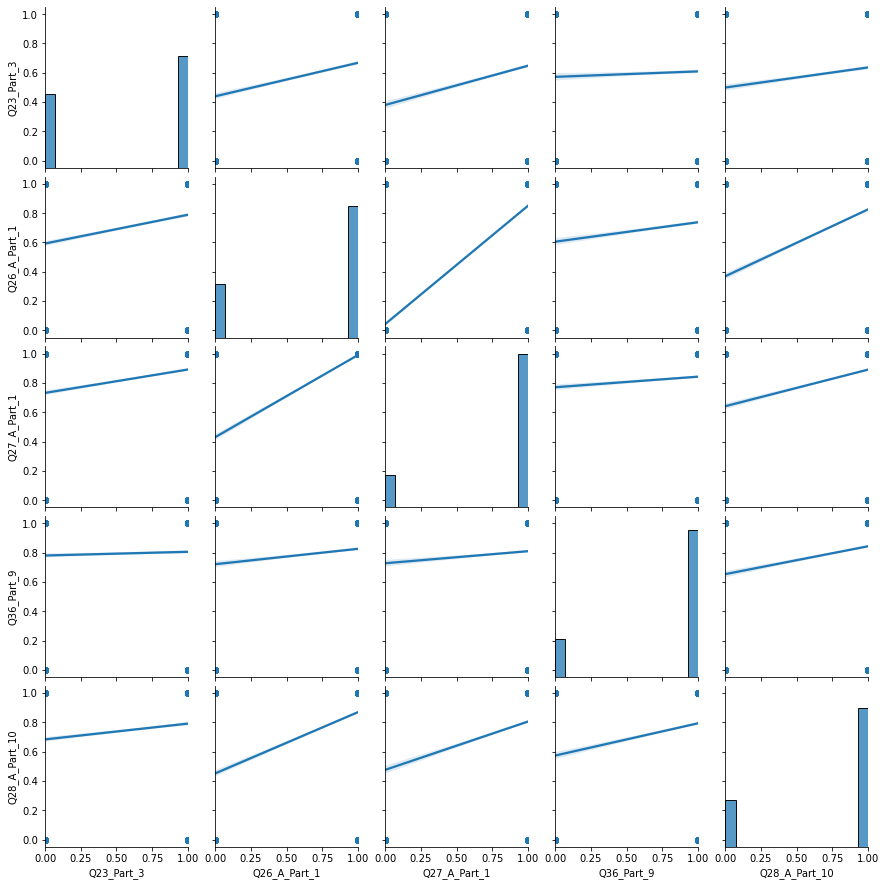

In [18]:
#4. pair-wise negative correlation between top 5 features
plt.figure(figsize=(5,5))
features_neg = df.loc[:,(relation_neg.index[:5])]

sns.pairplot(features_neg, kind='reg')
plt.show()

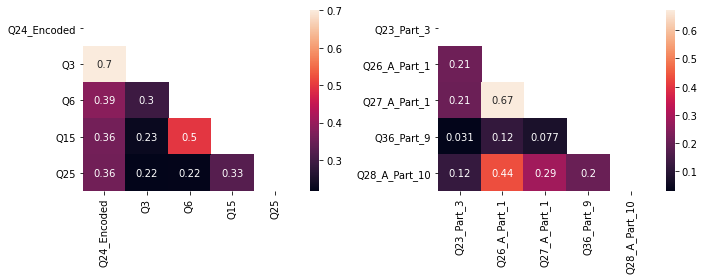

In [19]:
#4. pair-wise correlation in heatmap
mask = np.zeros_like(features_pos.corr()*-1)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(10, 1 * 4))
plt.subplot(1, 2, 1)
sns.heatmap(features_pos.corr(), mask=mask, annot=True)

mask = np.zeros_like(features_neg.corr()*-1)
mask[np.triu_indices_from(mask)] = True

plt.subplot(1, 2, 2)
sns.heatmap(features_neg.corr(), mask=mask, annot=True)
plt.tight_layout()

**Feature Engineering and Selection:**
1. Split data in 70% training data and 30% test data.
2. Implement regularized regression-lasso regression to reduce number of features.
3. Use these non-zero-coefficient features to train the data.
3. Use chi-square test between each feature and target variable for feature selection.

In [20]:
# 1) Split data in 70% training data and 30% test data
x = df.drop(['Q24','Q24_Encoded','Q24_buckets'], axis=1)
y = df['Q24_Encoded']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

df_train = pd.concat([x_train, y_train], axis = 1)

In [21]:
# 2) use grid search to find best parameters of Lasso with optimal r2_score based on training data
from sklearn.metrics import make_scorer, r2_score, confusion_matrix

lasso_gridsearch = Lasso(random_state=0)
#Parameters to test
parameters = {'alpha':[0.001,0.005,0.01,0.05,0.1,0.5,1,1.5], # Constant that multiplies the L1 term. Defaults to 1.0.
             'normalize':[True,False]} #

# Compare parameters by score of model 
myscorer = make_scorer(r2_score)
ss = StandardScaler()

# Run the grid search
grid_lasso = GridSearchCV(lasso_gridsearch, parameters,scoring=myscorer)
grid_lasso = grid_lasso.fit(x_train, y_train)

lasso_gridsearch = grid_lasso.best_estimator_  #Select best parameter combination
lasso_gridsearch

print('alpha (Constant that multiplies the L1 term):',grid_lasso.best_estimator_.alpha) 
print('normalize:',grid_lasso.best_estimator_.normalize)

alpha (Constant that multiplies the L1 term): 0.01
normalize: False


In [22]:
# 3) Lasso: use the optimal parameters
lasso = Lasso(alpha = 0.01,normalize=False)
lasso.fit(x_train, y_train)
print("The Lasso score of training data:", lasso.score(x_train, y_train))

lasso.fit(x_test, y_test)
print("The Lasso score of testing data:", lasso.score(x_test, y_test))

# print out coefficients of different features
# print out features that have coefficients not equal to 0
lasso_result=pd.DataFrame(list(zip(lasso.coef_, x_train.columns)), columns=['coefficient','feature_name']).sort_values('coefficient',ascending=False)
lasso_result = lasso_result[abs(lasso_result['coefficient'])!=0]
lasso_result['feature_name'].tolist()

# reduce features on training dataset
x_train = x_train[lasso_result['feature_name'].tolist()]

The Lasso score of training data: 0.6110461931588504
The Lasso score of testing data: 0.6356959670571191


In [23]:
x_train.shape

(5434, 121)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'Q3'),
  Text(1, 0, 'Q1'),
  Text(2, 0, 'Q15'),
  Text(3, 0, 'Q25'),
  Text(4, 0, 'Q21'),
  Text(5, 0, 'Q6'),
  Text(6, 0, 'Q20'),
  Text(7, 0, 'Q22'),
  Text(8, 0, 'Q23_Part_3'),
  Text(9, 0, 'Q26_A_Part_1'),
  Text(10, 0, 'Q35_A_Part_10'),
  Text(11, 0, 'Q2'),
  Text(12, 0, 'Q4'),
  Text(13, 0, 'Q7_Part_3'),
  Text(14, 0, 'Q12_Part_3'),
  Text(15, 0, 'Q27_A_Part_1'),
  Text(16, 0, 'Q23_Part_1'),
  Text(17, 0, 'Q17_Part_3'),
  Text(18, 0, 'Q37_Part_1'),
  Text(19, 0, 'Q10_Part_2'),
  Text(20, 0, 'Q17_Part_1'),
  Text(21, 0, 'Q5'),
  Text(22, 0, 'Q39_Part_4'),
  Text(23, 0, 'Q23_Part_2'),
  Text(24, 0, 'Q11'),
  Text(25, 0, 'Q13'),
  Text(26, 0, 'Q29_A_Part_2'),
  Text(27, 0, 'Q7_Part_2'),
  Text(28, 0, 'Q23_Part_4'),
  Text(29, 0, 'Q16_Part_1')])

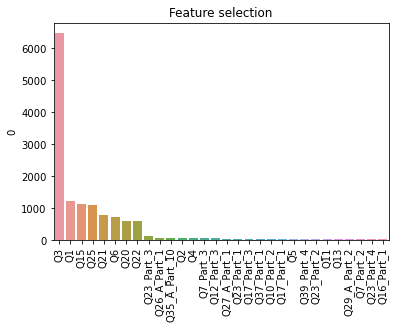

In [24]:
# 4) Chi-square test feature selection
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(x_train, y_train)
x_train_fs = fs.transform(x_train)

chi_score = pd.DataFrame(fs.scores_, index=x_train.columns)
chi_score=chi_score.sort_values(by=chi_score.columns[0],ascending=False)

sns.barplot(x=chi_score[:30].index, y=chi_score[:30].iloc[:,0], data=chi_score[:30])
plt.title('Feature selection')
plt.xticks(rotation=90)

Check filtered features' collinearity using VIF

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
x_train_new = x_train[chi_score[:30].index[0:30].tolist()]
vif_data = pd.DataFrame()
vif_data["feature"] = x_train_new.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train_new.values, i)
                          for i in range(len(x_train_new.columns))]

vif_data

,feature,VIF
0,Q3,3.146397
1,Q1,5.426861
2,Q15,5.244532
3,Q25,3.821528
4,Q21,4.451174
5,Q6,9.882911
6,Q20,3.337204
7,Q22,3.854078
8,Q23_Part_3,3.442810
9,Q26_A_Part_1,6.959367


# 3. Model Implementation

Prepare x_train and x_test with selected features. Notice that target variable is splitted into 15 classes.

In [26]:
# 30 features in total will be used
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

x_train_new = x_train[chi_score[:60].index[0:30].tolist()]
x_test_new = x_test[chi_score[:60].index[0:30].tolist()]


**Write the ordinal multi-class logistic algorithmn.**

In [27]:
# ordinal multi-class logistic algorithmn
def ordmulti (x_train_new, y_train, x_test_new, c, solver):

    prob=[]
    p0 = 0
    model = LogisticRegression(C=c, solver=solver)

    for i in range(1,15):
        scaler = StandardScaler()
        x_train_new = scaler.fit_transform(x_train_new)
        x_test_new = scaler.transform(x_test_new)

        target_train = pd.DataFrame()
        target_train = y_train.replace(to_replace=np.arange(0,i).tolist(), value=np.zeros(len(np.arange(0,i))))
        target_train = target_train.replace(to_replace=np.arange(i,15).tolist(), value=np.ones(len(np.arange(i,15))))
        
        model.fit(x_train_new, target_train)

        ptotal = model.predict_proba(x_test_new)[:,0]
        p1=ptotal-p0
        prob.append(p1.tolist())
        p0=ptotal
    
        if i==14:
            p1 = (model.predict_proba(x_test_new)[:,1]).tolist()
            prob.append(p1)

    p=np.array(prob).T
    p = pd.DataFrame(p)
    p['max_class'] = p.idxmax(axis=1)

    return p['max_class']

In [28]:
# set the accuracy metric using idea of confusion matrix
def find_TP(y_true,y_pred):
#counts the number of true positives
    return sum((y_true ==1) & (y_pred ==1))

def find_FN(y_true,y_pred):
#counts the number of false negatives
    return sum((y_true ==1) & (y_pred ==0))

def find_FP(y_true,y_pred):
# countsthe number of false positives
    return sum((y_true ==0) & (y_pred ==1))

def find_TN(y_true,y_pred):
#counts the number of true negatives
    return sum((y_true ==0) & (y_pred ==0))

def find_conf_matrix_values(y_true,y_pred):
#calculate TP, FN, FP, TN
    TP=find_TP(y_true,y_pred)

    FN=find_FN(y_true,y_pred)

    FP=find_FP(y_true,y_pred)

    TN=find_TN(y_true,y_pred)

    return TP,FN,FP,TN

**1. 10-fold cross validation**   

**2. try a new model**


In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#import warnings
#warnings.filterwarnings('ignore')

#scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(x_train_new)

accuracy = np.zeros(10)
acc=[]
fscore=[]
np_idx = 0

for train_idx, test_idx in kfold.split(x_train_new):
    X_train, X_test = x_train_new.iloc[train_idx], x_train_new.iloc[test_idx]

    Y_train, Y_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    predictions = ordmulti(X_train, Y_train, X_test, c=1, solver='lbfgs')
    
    TP,FN,FP,TN = find_conf_matrix_values(Y_test,predictions)

    total = TN + FP + FN + TP
    ACC = (TP + TN) / float(total)  
    
    accuracy[np_idx] = ACC*100
    acc.append(accuracy_score(Y_test,predictions)*100)
    fscore.append(f1_score(Y_test,predictions,average='weighted')*100)
    np_idx += 1
    
    print ("Fold {}: Precision Accuracy: {}%. Accuracy Score:{}. F1-score:{}".format(np_idx, round(ACC,3), accuracy_score(Y_test,predictions)*100,f1_score(Y_test,predictions,average='weighted')*100))   

print ("Average Precision Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))
print("Average Accuracy Score:{}%({}%)".format(round(np.mean(acc),5),round(np.std(acc),3)))
print("Average F1-Score: {}({}%)".format(round(np.mean(fscore),5),round(np.std(fscore),3)))

Fold 1: Precision Accuracy: 0.5%. Accuracy Score:43.93382352941176. F1-score:35.195659289685096
Fold 2: Precision Accuracy: 0.625%. Accuracy Score:42.463235294117645. F1-score:32.93575368339756
Fold 3: Precision Accuracy: 1.0%. Accuracy Score:41.544117647058826. F1-score:32.385621713298804
Fold 4: Precision Accuracy: 0.625%. Accuracy Score:45.220588235294116. F1-score:35.72416969009796
Fold 5: Precision Accuracy: 0.769%. Accuracy Score:42.35727440147329. F1-score:32.060219427454065
Fold 6: Precision Accuracy: 0.9%. Accuracy Score:43.646408839779006. F1-score:34.65207606958943
Fold 7: Precision Accuracy: 0.636%. Accuracy Score:39.41068139963168. F1-score:28.206487962669158
Fold 8: Precision Accuracy: 0.75%. Accuracy Score:47.14548802946593. F1-score:37.68964074637409
Fold 9: Precision Accuracy: 0.75%. Accuracy Score:44.19889502762431. F1-score:36.420128914685804
Fold 10: Precision Accuracy: 1.0%. Accuracy Score:40.147329650092075. F1-score:29.89198191326604
Average Precision Score: 75.5

In [30]:
# try a new model: 5 cross validation
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#import warnings
#warnings.filterwarnings('ignore')

#scaler = StandardScaler()
kfold = KFold(n_splits=5)
kfold.get_n_splits(x_train_new)

accuracy = np.zeros(5)
acc=[]
fscore=[]
np_idx = 0

for train_idx, test_idx in kfold.split(x_train_new):
    X_train, X_test = x_train_new.iloc[train_idx], x_train_new.iloc[test_idx]

    Y_train, Y_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    predictions = ordmulti(X_train, Y_train, X_test, c=1, solver='lbfgs')
    
    TP,FN,FP,TN = find_conf_matrix_values(Y_test,predictions)

    total = TN + FP + FN + TP
    ACC = (TP + TN) / float(total)  
    
    accuracy[np_idx] = ACC*100
    acc.append(accuracy_score(Y_test,predictions)*100)
    fscore.append(f1_score(Y_test,predictions,average='weighted')*100)
    np_idx += 1
    
    print ("Fold {}: Precision Accuracy: {}%. Accuracy Score:{}. F1-score:{}".format(np_idx, round(ACC,3), accuracy_score(Y_test,predictions)*100,f1_score(Y_test,predictions,average='weighted')*100))   

print ("Average Precision Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))
print("Average Accuracy Score:{}%({}%)".format(round(np.mean(acc),5),round(np.std(acc),3)))
print("Average F1-Score: {}({}%)".format(round(np.mean(fscore),5),round(np.std(fscore),3)))

Fold 1: Precision Accuracy: 0.658%. Accuracy Score:43.146274149034035. F1-score:34.4169624864407
Fold 2: Precision Accuracy: 0.885%. Accuracy Score:43.51425942962281. F1-score:34.525258499997534
Fold 3: Precision Accuracy: 0.72%. Accuracy Score:43.054277828886846. F1-score:33.689735550242304
Fold 4: Precision Accuracy: 0.73%. Accuracy Score:42.96228150873965. F1-score:32.66044114705296
Fold 5: Precision Accuracy: 0.848%. Accuracy Score:41.62062615101289. F1-score:32.684854263952914
Average Precision Score: 76.814%(8.482%)
Average Accuracy Score:42.85954%(0.647%)
Average F1-Score: 33.59545(0.806%)


# 4. Model Tuning

two hyperparameters: number of splits in kfold, logistic solver

In [31]:

total_result = []
for c in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]:
    result_solver = []
    for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
        #print('Solver:' + solver)
        acc_score=[]

        kfold = KFold(n_splits=5)
        kfold.get_n_splits(x_train_new)

        accuracy = np.zeros(5)
        np_idx = 0

        for train_idx, test_idx in kfold.split(x_train_new):
            X_train, X_test = x_train_new.iloc[train_idx], x_train_new.iloc[test_idx]

            Y_train, Y_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
            predictions = ordmulti(X_train, Y_train, X_test, c=c, solver=solver)
    
            #TP,FN,FP,TN = find_conf_matrix_values(Y_test,predictions)

            #total = TN + FP + FN + TP
            #ACC = (TP + TN) / float(total)
            ACC=f1_score(Y_test,predictions,average='weighted')  
    
            accuracy[np_idx] = ACC*100
            np_idx += 1
       
        result_solver.append(round(np.mean(accuracy),3))
    total_result.append(result_solver)

    
total_result

[[26.357, 26.357, 27.175, 26.357, 26.357],
 [30.414, 30.414, 29.097, 30.414, 30.414],
 [31.798, 31.798, 30.629, 31.798, 31.797],
 [33.434, 33.434, 32.727, 33.434, 33.434],
 [33.581, 33.581, 33.484, 33.581, 33.582],
 [33.61, 33.61, 33.564, 33.608, 33.61],
 [33.595, 33.595, 33.576, 33.593, 33.567]]

In [32]:
total_result = np.array(total_result)

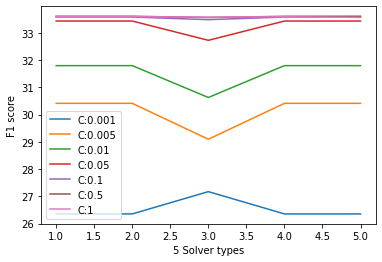

In [33]:
# plot the F1 scores under the hyperparameter tuning
x=[1, 2, 3, 4, 5]
y=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]


fig = plt.figure()
for i in range(len(total_result)):
    plt.plot(x, total_result[i],label='C:%s'%y[i])
    plt.xlabel('5 Solver types')
    plt.ylabel('F1 score')

plt.legend()

# 5. Testing

In [34]:
# apply the optimal model on the testing data
pred = ordmulti (x_train_new, y_train, x_test_new, c=0.5, solver='lbfgs')

print('Accuracy score of testing data:', accuracy_score(y_test, pred))
print('F1 score of testing data:', f1_score(y_test,pred, average='weighted')*100)
print('MSE of testing data:', mean_squared_error(y_test,pred))
print(classification_report(y_test, pred))

Accuracy score of testing data: 0.45879828326180255
F1 score of testing data: 36.31593471506975
MSE of testing data: 9.599570815450644
              precision    recall  f1-score   support

         0.0       0.58      0.95      0.72       989
         1.0       0.22      0.03      0.05       259
         2.0       0.17      0.03      0.05       175
         3.0       0.15      0.02      0.03       107
         4.0       0.20      0.09      0.12       111
         5.0       0.12      0.13      0.13       100
         6.0       0.17      0.04      0.07        91
         7.0       0.11      0.05      0.07        76
         8.0       0.12      0.02      0.03        53
         9.0       0.07      0.01      0.02        67
        10.0       0.21      0.37      0.26       121
        11.0       0.13      0.14      0.14        58
        12.0       0.27      0.39      0.32        74
        13.0       0.50      0.05      0.09        20
        14.0       0.50      0.07      0.12        29


In [35]:
# apply the optimal model on the training data
pred_train = ordmulti (x_train_new, y_train, x_train_new, c=0.5, solver='lbfgs')

print('Accuracy score of training data:', accuracy_score(y_train, pred_train))
print('F1 score of training data:', f1_score(y_train,pred_train, average='weighted')*100)
print('MSE of training data:', mean_squared_error(y_train,pred_train))
print(classification_report(y_train, pred_train))

Accuracy score of training data: 0.45049687154950313
F1 score of training data: 35.576426866765686
MSE of training data: 10.80437983069562
              precision    recall  f1-score   support

         0.0       0.56      0.94      0.70      2213
         1.0       0.15      0.02      0.04       567
         2.0       0.24      0.05      0.08       342
         3.0       0.17      0.01      0.02       275
         4.0       0.24      0.09      0.13       292
         5.0       0.19      0.16      0.17       265
         6.0       0.09      0.03      0.05       198
         7.0       0.16      0.08      0.10       206
         8.0       0.08      0.01      0.02       148
         9.0       0.20      0.03      0.06       147
        10.0       0.20      0.38      0.26       302
        11.0       0.30      0.26      0.28       174
        12.0       0.29      0.37      0.32       179
        13.0       0.33      0.12      0.18        66
        14.0       0.38      0.05      0.09       

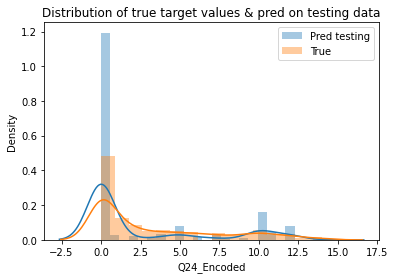

In [36]:
# plot distribution of true target and predictions on test data
import warnings
warnings.filterwarnings('ignore')

sns.distplot(pred, label='Pred testing')
sns.distplot(y_test, label='True')
plt.title('Distribution of true target values & pred on testing data')
plt.legend()

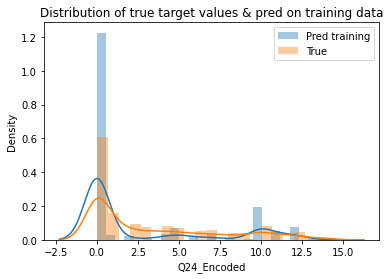

In [37]:
# plot distribution of true target and predictions on training data
import warnings
warnings.filterwarnings('ignore')

sns.distplot(ordmulti (x_train_new, y_train, x_train_new, c=0.5, solver='lbfgs'), label='Pred training')
sns.distplot(y_train, label='True')
plt.title('Distribution of true target values & pred on training data')
plt.legend()